In [1]:
from src.rel_prop.min_max_rel_model import MinMaxModel, Nested_Regressor
from src.models.Binary_Mnist_Model import Montavon_Classifier
import numpy as np
from src.rel_prop.minmax_utils import get_higher_relevances
import matplotlib.pyplot as plt

In [2]:
mc = Montavon_Classifier(class_nb=8, load_model=True)
mc.set_data(test_size=0.2)
mc.set_model()
mc.model.summary()
mc.fit_model(epochs=300, batch_size=32)

Train images: 21840, train labels: 21840
Load model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 400)               313600    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               40000     
_________________________________________________________________
dense_2 (Dense)              (None, 400)               40000     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 400       
Total params: 394,000
Trainable params: 353,600
Non-trainable params: 40,400
_________________________________________________________________
Model has been load, no need to train!


In [3]:
print("\nAccuracy on the test data set: {}".format(mc.evaluate(batch_size=32)))

171/171 [==============================] - 0s 1ms/step - loss: 0.8590 - acc: 0.9480

Accuracy on the test data set: 0.9479853510856628


In [4]:
print("\nAccuracy on all test images labeled with 1: {}".format(mc.non_trivial_accuracy()))


Accuracy on all test images labeled with 1: 0.8147877013177159


In [5]:
# use to recalc relevances for the training of the min max model. Therefore set recalc_rel to True
a,b,c = get_higher_relevances(classifier=mc, recalc_rel=False, use_higher_rel=True)

Started to collect relevances to train min-max-model!
Info: You decided to use higher relevances for training.
Load relevances to train min-max-model from local directory!


In [6]:
minmax = MinMaxModel(classifier=mc, use_higher_rel=True)

Started to collect relevances to train min-max-model!
Info: You decided to use higher relevances for training.
Load relevances to train min-max-model from local directory!
Created MinMaxModel


In [7]:
# Create a nested regressor to varify that fitting works

nr = Nested_Regressor(input_shape=(28,28), use_bias=True, neuron_index=0)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
bias_input (InputLayer)         [(None, 400, 1)]     0                                            
__________________________________________________________________________________________________
flat_image (Flatten)            (None, 784)          0           image_input[0][0]                
__________________________________________________________________________________________________
flat_bias (Flatten)             (None, 400)          0           bias_input[0][0]                 
______________________________________________________________________________________________

In [8]:
nr.model.layers[-2].weights[0]

# -> Die es werden je zwei Neuronen im Abstand von 100 aus dem concatenate Layer miteinander addiert

<tf.Variable 'add_up_layer/kernel:0' shape=(200, 100) dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)>

In [9]:
nr.model.layers[-2].activation

<function tensorflow.python.keras.activations.relu(x, alpha=0.0, max_value=None, threshold=0)>

In [10]:
nr_train_images = minmax.nr_train_images
true_relevances = minmax.true_relevances
higher_relevances = minmax.higher_relevances

In [11]:
print(type(nr_train_images))
print(nr_train_images.shape)
print(nr_train_images[0].shape)

<class 'numpy.ndarray'>
(4607, 28, 28)
(28, 28)


In [12]:
print(type(true_relevances))
print(true_relevances.shape)
print(true_relevances[0].shape)

<class 'numpy.ndarray'>
(100, 4607)
(4607,)


In [13]:
print(type(higher_relevances))
print(higher_relevances.shape)
print(higher_relevances[0].shape)

# -> higher relevances werden vor dem Training im Nested Regressor transponiert

print(np.transpose(higher_relevances)[0].shape)

<class 'numpy.ndarray'>
(400, 4607)
(4607,)
(400,)


In [14]:
history0 = nr.fit_approx_model(train_images=nr_train_images, true_relevances=true_relevances[0], higher_relevances=higher_relevances)

116 [==============================] - 0s 2ms/step - loss: 1.7188e-06 - mse: 1.7188e-06 - val_loss: 20.3198 - val_mse: 20.3198
Epoch 1023/3000
116/116 [==============================] - 0s 2ms/step - loss: 1.7188e-06 - mse: 1.7188e-06 - val_loss: 20.3198 - val_mse: 20.3198
Epoch 1024/3000
116/116 [==============================] - 0s 2ms/step - loss: 1.7188e-06 - mse: 1.7188e-06 - val_loss: 20.3198 - val_mse: 20.3198
Epoch 1025/3000
116/116 [==============================] - 0s 2ms/step - loss: 1.7188e-06 - mse: 1.7188e-06 - val_loss: 20.3198 - val_mse: 20.3198
Epoch 1026/3000
116/116 [==============================] - 0s 2ms/step - loss: 1.7188e-06 - mse: 1.7188e-06 - val_loss: 20.3198 - val_mse: 20.3198
Epoch 1027/3000
116/116 [==============================] - 0s 2ms/step - loss: 1.7188e-06 - mse: 1.7188e-06 - val_loss: 20.3198 - val_mse: 20.3198
Epoch 1028/3000
116/116 [==============================] - 0s 2ms/step - loss: 1.7188e-06 - mse: 1.7188e-06 - val_loss: 20.3198 - val_mse:

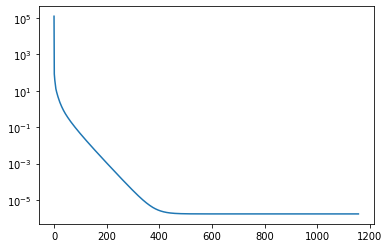

In [15]:
plt.plot(history0.history['loss'])
plt.plot(history0.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.yscale('log')
plt.show()

In [16]:
nr1 = Nested_Regressor(input_shape=(28,28), use_bias=True, neuron_index=1)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
bias_input (InputLayer)         [(None, 400, 1)]     0                                            
__________________________________________________________________________________________________
flat_image (Flatten)            (None, 784)          0           image_input[0][0]                
__________________________________________________________________________________________________
flat_bias (Flatten)             (None, 400)          0           bias_input[0][0]                 
____________________________________________________________________________________________

In [17]:
history1 = nr1.fit_approx_model(train_images=nr_train_images, true_relevances=true_relevances[1], higher_relevances=higher_relevances)

l_mse: 2.0199
Epoch 703/3000
116/116 [==============================] - 0s 2ms/step - loss: 7.4895e-06 - mse: 7.4895e-06 - val_loss: 2.0199 - val_mse: 2.0199
Epoch 704/3000
116/116 [==============================] - 0s 2ms/step - loss: 7.4895e-06 - mse: 7.4895e-06 - val_loss: 2.0199 - val_mse: 2.0199
Epoch 705/3000
116/116 [==============================] - 0s 2ms/step - loss: 7.4895e-06 - mse: 7.4895e-06 - val_loss: 2.0199 - val_mse: 2.0199
Epoch 706/3000
116/116 [==============================] - 0s 2ms/step - loss: 7.4895e-06 - mse: 7.4895e-06 - val_loss: 2.0199 - val_mse: 2.0199
Epoch 707/3000
116/116 [==============================] - 0s 2ms/step - loss: 7.4895e-06 - mse: 7.4895e-06 - val_loss: 2.0199 - val_mse: 2.0199
Epoch 708/3000
116/116 [==============================] - 0s 2ms/step - loss: 7.4895e-06 - mse: 7.4895e-06 - val_loss: 2.0199 - val_mse: 2.0199
Epoch 709/3000
116/116 [==============================] - 0s 2ms/step - loss: 7.4895e-06 - mse: 7.4895e-06 - val_loss: 2.0

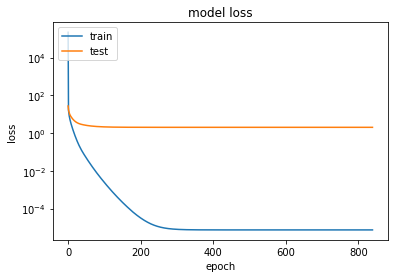

In [18]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.yscale('log')
plt.show()